Epoch 1/10 running...
Epoch 1 completed.
Epoch 2/10 running...
Epoch 2 completed.
Epoch 3/10 running...
Epoch 3 completed.
Epoch 4/10 running...
Epoch 4 completed.
Epoch 5/10 running...
Epoch 5 completed.
Epoch 6/10 running...
Epoch 6 completed.
Epoch 7/10 running...
Epoch 7 completed.
Epoch 8/10 running...
Epoch 8 completed.
Epoch 9/10 running...
Epoch 9 completed.
Epoch 10/10 running...
Epoch 10 completed.


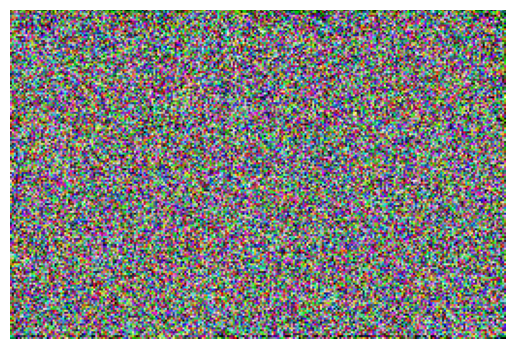

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
import customtkinter as ctk
from customtkinter import CTkImage
import tensorflow as tf
import numpy as np

# Function to convert a tensor to an image
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        tensor = tensor[0]
    return Image.fromarray(tensor)

# Function to load an image and scale it to 512px max dimension
def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(shape, tf.float32)  # Cast to float32 for multiplication
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)  # Scale and cast back to int32

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image
# Preprocessing functions for the VGG model
def preprocess_image(image):
    '''Preprocesses the image to match the input requirements of the VGG19 model'''
    image = tf.cast(image, tf.float32)  # Cast image to float32
    image = tf.keras.applications.vgg19.preprocess_input(image * 255.0)  # Multiply and preprocess
    return image


# Gram matrix calculation to extract style
def gram_matrix(input_tensor):
    '''Calculates the gram matrix of the given tensor'''
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Function to extract style image features
def get_style_image_features(image, vgg_model):
    '''Extracts style features from the given image'''
    preprocessed_image = preprocess_image(image)
    outputs = vgg_model(preprocessed_image)
    style_outputs = outputs[:NUM_STYLE_LAYERS]
    style_features = [gram_matrix(style_output) for style_output in style_outputs]
    return style_features

# Function to extract content image features
def get_content_image_features(image, vgg_model):
    '''Extracts content features from the given image'''
    preprocessed_image = preprocess_image(image)
    outputs = vgg_model(preprocessed_image)
    content_outputs = outputs[NUM_STYLE_LAYERS:]
    return content_outputs

def vgg_model(layer_names):
    '''Creates a VGG model that returns the outputs of specific layers'''
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']
output_layers = style_layers + content_layers
NUM_STYLE_LAYERS = len(style_layers)
NUM_CONTENT_LAYERS = len(content_layers)

def get_style_content_loss(style_targets, style_outputs, content_targets, content_outputs, style_weight, content_weight):
    """Combines the style and content loss to compute total loss."""
    
    # Compute style loss by summing up all style layers losses
    style_loss = tf.add_n([tf.reduce_mean(tf.square(style_output - style_target)) 
                           for style_output, style_target in zip(style_outputs, style_targets)])
    style_loss *= style_weight / NUM_STYLE_LAYERS
    
    # Compute content loss
    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_output - content_target)) 
                             for content_output, content_target in zip(content_outputs, content_targets)])
    content_loss *= content_weight / NUM_CONTENT_LAYERS
    
    # Total loss is the sum of style and content loss
    total_loss = style_loss + content_loss
    
    return total_loss

def clip_image_values(image, min_value=0.0, max_value=255.0):
    """Clips the pixel values of the image to stay within the valid range."""
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)



# Function to perform neural style transfer
# Function to perform neural style transfer with style transfer logic
def fit_style_transfer(content_image, style_image, epochs=10, steps_per_epoch=10):
    # Load VGG model (without the fully connected layers)
    vgg = vgg_model(output_layers)

    # Extract the style and content features from the images
    style_targets = get_style_image_features(style_image, vgg)
    content_targets = get_content_image_features(content_image, vgg)

    # Ensure the content image is cast to float32 before creating the variable
    content_image = tf.image.convert_image_dtype(content_image, dtype=tf.float32)

    # Initialize the generated image
    generated_image = tf.Variable(content_image, dtype=tf.float32)

    # Define the optimizer
    optimizer = tf.optimizers.Adam(
        tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
        )
    )

    for epoch in range(epochs):
        
        print(f"Epoch {epoch + 1}/{epochs} running...")
        
        for step in range(steps_per_epoch):
            # Calculate gradients and update the image
            with tf.GradientTape() as tape:
                style_outputs = get_style_image_features(generated_image, vgg)
                content_outputs = get_content_image_features(generated_image, vgg)
                total_loss = get_style_content_loss(style_targets, style_outputs,
                                                    content_targets, content_outputs,
                                                    style_weight=2e-2, content_weight=1e-2)
            gradients = tape.gradient(total_loss, generated_image)
            optimizer.apply_gradients([(gradients, generated_image)])
            generated_image.assign(clip_image_values(generated_image, 0.0, 255.0))
            
        print(f"Epoch {epoch + 1} completed.")

    return generated_image




# Function to open file dialog and select image
# Function to open file dialog and select image
def select_image(image_type):
    filepath = filedialog.askopenfilename()
    if image_type == 'content':
        content_image_path.set(filepath)
        img = Image.open(filepath)
        img = img.resize((150, 150), Image.Resampling.LANCZOS)
        content_img_label.imgtk = CTkImage(light_image=img, size=(150, 150))  # Use CTkImage
        content_img_label.configure(image=content_img_label.imgtk)
    elif image_type == 'style':
        style_image_path.set(filepath)
        img = Image.open(filepath)
        img = img.resize((150, 150), Image.Resampling.LANCZOS)
        style_img_label.imgtk = CTkImage(light_image=img, size=(150, 150))  # Use CTkImage
        style_img_label.configure(image=style_img_label.imgtk)


# Function to start the style transfer process
def start_style_transfer():
    content_image = load_img(content_image_path.get())
    style_image = load_img(style_image_path.get())
    output_image = fit_style_transfer(content_image, style_image)

    # Display the final stylized image
    stylized_image_pil = tensor_to_image(output_image)
    stylized_image_pil = stylized_image_pil.resize((150, 150), Image.Resampling.LANCZOS)

    result_image_ctk = CTkImage(light_image=stylized_image_pil, size=(150, 150))
    result_img_label.configure(image=result_image_ctk)
    
    

# Initialize the main window
root = ctk.CTk()
root.geometry("600x400")
root.title("Neural Style Transfer")

# Content and Style Image Paths
content_image_path = ctk.StringVar()
style_image_path = ctk.StringVar()

# Title Label
title_label = ctk.CTkLabel(root, text="Neural Style Transfer", font=('Arial', 20))
title_label.pack(pady=20)

# Select Content Image
content_btn = ctk.CTkButton(root, text="Select Content Image", command=lambda: select_image('content'))
content_btn.pack(pady=10)
content_img_label = ctk.CTkLabel(root, text="No Image Selected")
content_img_label.pack()

# Select Style Image
style_btn = ctk.CTkButton(root, text="Select Style Image", command=lambda: select_image('style'))
style_btn.pack(pady=10)
style_img_label = ctk.CTkLabel(root, text="No Image Selected")
style_img_label.pack()

# Start Style Transfer Button
start_btn = ctk.CTkButton(root, text="Start Style Transfer", command=start_style_transfer)
start_btn.pack(pady=20)

# Result Image
result_img_label = ctk.CTkLabel(root, text="Result will be displayed here")
result_img_label.pack()

# Run the application
root.mainloop()

